### 시황별 어떤 팩터가 좋은지 확인

In [2]:
from econ_regime.econ_regime import business_cycle, asset_indicators
from price.macro_info import get_econ_info
from strategy.factors.beta import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

In [3]:
indexes_df = asset_indicators()
indexes_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,TLT,GSG,VNQ,UUP
1993-01-29,25.218229,NaN,NaN,NaN,NaN
1993-02-01,25.397593,NaN,NaN,NaN,NaN
1993-02-02,25.451399,NaN,NaN,NaN,NaN
1993-02-03,25.720432,NaN,NaN,NaN,NaN
1993-02-04,25.828062,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-02-02,416.779999,108.320000,20.469999,93.699997,27.430000
2023-02-03,412.350006,106.699997,19.990000,91.940002,27.790001
2023-02-06,409.829987,105.910004,20.129999,91.269997,27.950001
2023-02-07,415.190002,105.059998,20.590000,91.070000,27.900000


### 주식 베타

In [4]:
equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

In [5]:
equity_universe = equity_df.loc['2011':,].dropna(axis=1)
equity_universe

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.163610,10.040195,60.552662,10.033263,28.549282,17.639103,9.832222,38.638706,31.290001,28.432861,...,73.060722,12.822729,77.632805,15.788007,46.502182,32.227661,28.031958,48.627453,38.200001,21.050661
2011-01-04,26.910648,10.011914,57.538910,10.085626,28.233181,17.805092,9.771111,38.384243,31.510000,28.110697,...,71.834747,12.686455,80.054596,15.855021,46.720490,31.869568,27.603678,47.981678,37.840000,20.707764
2011-01-05,26.852272,10.464432,57.612873,10.168124,28.665747,17.805092,9.785556,38.392178,32.220001,28.170630,...,72.832153,13.082301,81.087448,15.761208,46.595737,32.172558,27.735012,48.017067,37.799999,20.824848
2011-01-06,26.904169,10.596415,55.717705,10.159907,28.998491,17.768208,9.653333,38.535332,32.270000,28.327969,...,73.039963,12.991453,81.678627,15.747799,46.895157,31.988941,27.929159,46.530907,37.480000,20.766296
2011-01-07,26.994974,10.747252,57.206089,10.232668,29.056715,17.841972,9.580000,38.598942,32.040001,28.163143,...,72.915298,13.348357,84.570541,15.888525,47.150887,31.860401,28.277491,46.522053,37.599998,20.548853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,156.562347,18.260000,224.063019,175.262802,127.924423,136.246506,43.480000,396.261078,569.619995,169.451675,...,232.187408,36.561798,88.879997,64.804298,58.691692,54.536747,132.787628,122.040504,582.409973,60.688782
2021-12-27,157.494980,18.170000,228.281143,179.289444,130.265030,138.498337,43.930000,408.070984,577.679993,172.209473,...,234.740433,37.526936,87.580002,65.008598,59.528496,55.048363,135.407288,123.061127,606.330017,61.321358
2021-12-28,157.931503,18.540001,229.854492,178.255432,130.719345,137.529068,44.270000,408.011993,569.359985,171.139740,...,234.406555,37.716183,86.459999,65.786911,59.336128,55.127079,135.377838,123.446266,597.320007,61.418682


In [6]:
equity_beta = Beta(price_df=equity_universe, benchmark_ticker='SPY').get_beta()

[*********************100%***********************]  1 of 1 completed


In [7]:
equity_beta

,beta
A,1.206718e+00
AAL,1.380078e+00
AAP,8.682432e-01
AAPL,1.096141e+00
ABC,8.210374e-01
...,...
ZBH,9.580065e-01
ZBRA,1.240413e+00
ZION,1.264472e+00
SPY,1.000000e+00


In [8]:
equity_beta.sort_values(by='beta', ascending=False).iloc[:20]

,beta
LNC,1.924299
URI,1.792291
FCX,1.726043
MGM,1.664742
AMP,1.648469
RCL,1.642662
MU,1.641177
IVZ,1.625838
APA,1.613829
ON,1.603625


### 상위 20개 기업의 누적 수익률과 상관계수 확인

In [9]:
top20_ticker = equity_beta.sort_values(by='beta', ascending=False).iloc[:20].index

AxesSubplot(0.125,0.11;0.775x0.77)


,LNC,URI,FCX,MGM,AMP,RCL,MU,IVZ,APA,ON,HAL,MS,C,MRO,DVN,NXPI,DXC,AMD,SIVB,RF
LNC,1.000000,0.625459,0.513740,0.604371,0.833376,0.633816,0.462637,0.756341,0.539365,0.536477,0.639037,0.765569,0.802246,0.535576,0.567833,0.491681,0.555382,0.300948,0.713788,0.791482
URI,0.625459,1.000000,0.531445,0.515729,0.616050,0.505957,0.462075,0.573312,0.455232,0.496754,0.568003,0.578091,0.588254,0.490093,0.511543,0.484495,0.450410,0.327095,0.554395,0.583910
FCX,0.513740,0.531445,1.000000,0.459191,0.514309,0.396715,0.384525,0.486121,0.499758,0.447885,0.559659,0.490073,0.498745,0.525950,0.539617,0.394463,0.395011,0.299842,0.453975,0.478984
MGM,0.604371,0.515729,0.459191,1.000000,0.577870,0.617787,0.428649,0.521101,0.462545,0.520804,0.525489,0.539960,0.577977,0.421624,0.448386,0.461041,0.481780,0.300716,0.491478,0.565163
AMP,0.833376,0.616050,0.514309,0.577870,1.000000,0.558168,0.483406,0.778626,0.488985,0.549117,0.578523,0.770152,0.782455,0.494571,0.515905,0.516015,0.562108,0.344268,0.715721,0.740127
RCL,0.633816,0.505957,0.396715,0.617787,0.558168,1.000000,0.361527,0.511316,0.448391,0.476616,0.514965,0.520621,0.586008,0.430494,0.448210,0.423673,0.428506,0.253221,0.490407,0.549407
MU,0.462637,0.462075,0.384525,0.428649,0.483406,0.361527,1.000000,0.463696,0.345699,0.584005,0.411969,0.460587,0.468821,0.361705,0.368835,0.540612,0.366725,0.426255,0.429912,0.440710
IVZ,0.756341,0.573312,0.486121,0.521101,0.778626,0.511316,0.463696,1.000000,0.462726,0.512871,0.543332,0.718835,0.722894,0.485376,0.492204,0.499858,0.498082,0.300381,0.665633,0.696157
APA,0.539365,0.455232,0.499758,0.462545,0.488985,0.448391,0.345699,0.462726,1.000000,0.397037,0.704857,0.455437,0.522235,0.768505,0.774821,0.353983,0.436199,0.223032,0.457863,0.504869
ON,0.536477,0.496754,0.447885,0.520804,0.549117,0.476616,0.584005,0.512871,0.397037,1.000000,0.479654,0.494139,0.523062,0.391045,0.434534,0.658322,0.479540,0.407999,0.493907,0.493769


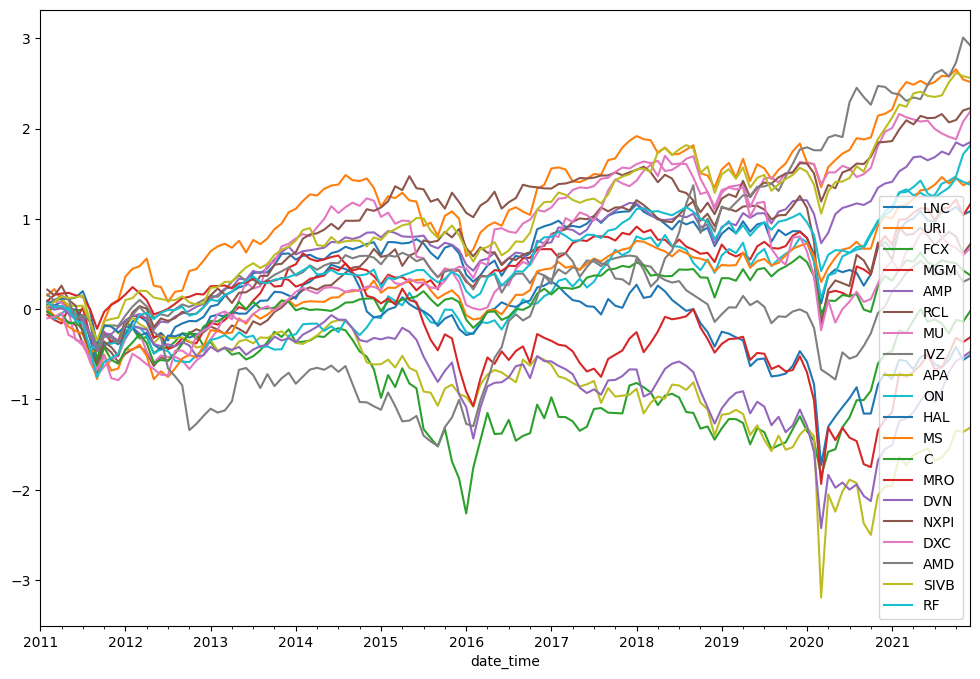

In [11]:
print(np.log(1 + equity_universe[top20_ticker].resample('M').last().pct_change()).cumsum().plot(figsize=(12, 8)))
equity_universe[top20_ticker].pct_change().dropna().corr()

### 결론
- 기업들의 상관계수가 높다 -> 움직임이 비슷하다.
- 즉, 미증시가 빠지면 함께 빠지게 된다

### spy index Versus beta20 portfolio cumulative returns

In [15]:
#print((1 + equity_universe[top20_ticker].pct_change().dropna().mean(axis=1)).cumprod().plot(figsize=(12, 8)))
Metric(portfolio=(1 + indexes_df.loc['2011':, 'SPY'].pct_change()).cumprod(), freq='day').print_report()
print()
Metric(portfolio=(1 + equity_universe[top20_ticker].pct_change().dropna().mean(axis=1)).cumprod()).print_report()

Annualized Return: 12.30%
Annualized Volatility: 17.58%
Skewness: -0.55
Kurtosis: 11.50
Max Drawdown: -33.72%
Max Drawdown Duration: 401 days
Annualized Sharp Ratio: 0.47
Annualized Sortino Ratio: -0.14
Annualized Calmar Ratio: 0.36
Annualized VaR: -0.03
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.55
Annualized GtP Ratio: 0.95

Annualized Return: 15.69%
Annualized Volatility: 31.77%
Skewness: -0.43
Kurtosis: 14.81
Max Drawdown: -64.48%
Max Drawdown Duration: 1032 days
Annualized Sharp Ratio: 0.37
Annualized Sortino Ratio: 0.01
Annualized Calmar Ratio: 0.24
Annualized VaR: -0.05
Annualized VaR Ratio: 0.01
Annualized CVaR: -0.08
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.54
Annualized GtP Ratio: 0.95


### 결론
- 지수보다 3%포인트 정도 높은 연율화 수익률을 보인다.
- 변동성 역시 약 14% 정도 높은 수준이다. 즉, 시장의 변동에 민감함을 알 수 있다.(베타의 의미 자체이기도 하다.)
- 변동성 대비 수익률 지표인 샤프비율 역시 지수가 더 양호함을 보인다.
- 베타의 MDD는 2배 정도로 상당히 높은 수준

### 다음 질문
- SPY의 성과지표가 시황에 따라 상이했던 것과 마찬가지로 베타의 성과지표 역시 시황에 영향을 받을 것이라 예상된다. 
- 이를 확인해고 시황을 반영한 포트폴리오의 성과지표가 향상 가능한지 백테스팅 진행해보자


In [19]:
top20_rets = equity_universe[top20_ticker].resample('M').last().pct_change().dropna().mean(axis=1)
top20_rets

date_time
2011-02-28    0.047852
2011-03-31   -0.013192
2011-04-30    0.010809
2011-05-31   -0.042016
2011-06-30   -0.060484
                ...   
2021-08-31    0.047454
2021-09-30    0.016810
2021-10-31    0.085261
2021-11-30   -0.011458
2021-12-31    0.042609
Freq: M, Length: 131, dtype: float64

In [22]:
regime_df = business_cycle()
regime_df = regime_df.loc['2011-02':'2021-12']
regime_df.index = top20_rets.index

In [23]:
top20_with_regime = pd.concat([top20_rets, regime_df], axis=1)
top20_with_regime.columns = ['beta20', 'deflation', 'inflation', 'recovery', 'expansion']
top20_with_regime

,beta20,deflation,inflation,recovery,expansion
date_time,,,,,
2011-02-28,0.047852,0,0,0,1
2011-03-31,-0.013192,0,0,0,1
2011-04-30,0.010809,0,0,0,0
2011-05-31,-0.042016,0,0,0,0
2011-06-30,-0.060484,0,0,0,0
...,...,...,...,...,...
2021-08-31,0.047454,0,0,0,0
2021-09-30,0.016810,0,0,0,0
2021-10-31,0.085261,0,0,0,0


### beta20 w/o market regime 
- 비교분석을 위해 시화을 반영하지 않은 beta20를 확인해보자

AxesSubplot(0.125,0.11;0.775x0.77)
Annualized Return: 14.65%
Annualized Volatility: 32.23%
Skewness: 0.07
Kurtosis: 4.89
Max Drawdown: -54.51%
Max Drawdown Duration: 1004 days
Annualized Sharp Ratio: 0.33
Annualized Sortino Ratio: -0.02
Annualized Calmar Ratio: 0.27
Annualized VaR: -0.18
Annualized VaR Ratio: 0.09
Annualized CVaR: -0.29
Annualized CVaR Ratio: 0.06
Annualized hit Ratio: 0.58
Annualized GtP Ratio: 1.18


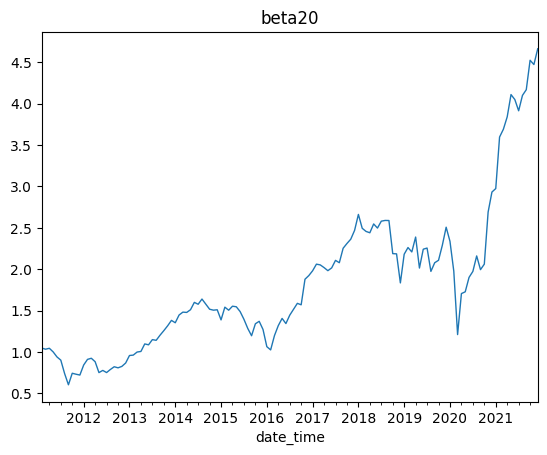

In [24]:
print((1 + top20_with_regime['beta20']).cumprod().plot(title='beta20', lw=1))
Metric(portfolio=(1 + top20_with_regime['beta20']).cumprod(), freq='month').print_report()

### beta20 with deflation

AxesSubplot(0.125,0.11;0.775x0.77)
Annualized Return: -5.32%
Annualized Volatility: 25.28%
Skewness: 0.24
Kurtosis: 14.22
Max Drawdown: -61.40%
Max Drawdown Duration: 3837 days
Annualized Sharp Ratio: -0.37
Annualized Sortino Ratio: -0.23
Annualized Calmar Ratio: -0.09
Annualized VaR: -0.18
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.29
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.52
Annualized GtP Ratio: 0.83


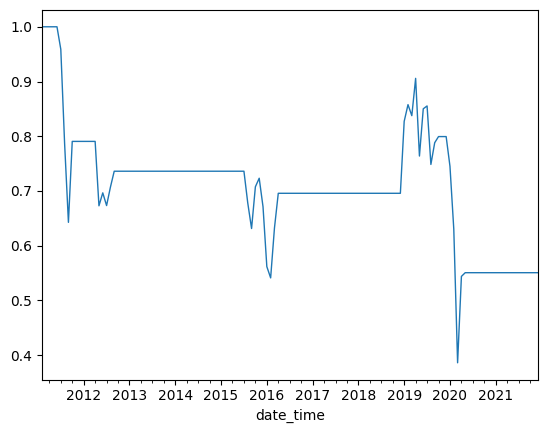

In [25]:
print((1 + top20_with_regime.beta20 * top20_with_regime.deflation).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.deflation).cumprod(), freq='month').print_report()

### beta20 with inflation

<AxesSubplot: xlabel='date_time'>

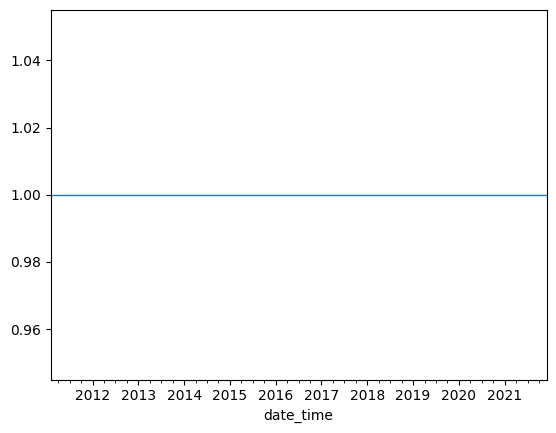

In [47]:
#(1 + top20_with_regime.beta20 * top20_with_regime.inflation).cumprod().plot(lw=1)
#Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.inflation).cumprod(), freq='month').print_report()

### beta20 with recovery

AxesSubplot(0.125,0.11;0.775x0.77)
Annualized Return: 14.69%
Annualized Volatility: 14.85%
Skewness: 3.79
Kurtosis: 19.73
Max Drawdown: -7.66%
Max Drawdown Duration: 822 days
Annualized Sharp Ratio: 0.72
Annualized Sortino Ratio: -0.80
Annualized Calmar Ratio: 1.92
Annualized VaR: -0.04
Annualized VaR Ratio: 0.27
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.20
Annualized hit Ratio: 0.69
Annualized GtP Ratio: 3.03


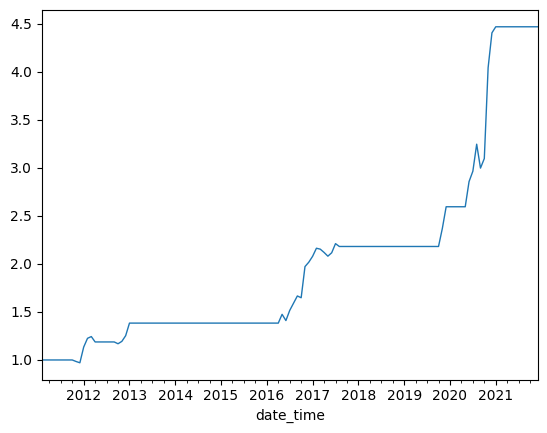

In [28]:
print((1 + top20_with_regime.beta20 * top20_with_regime.recovery).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.recovery).cumprod(), freq='month').print_report()

### beta20 with expansion

AxesSubplot(0.125,0.11;0.775x0.77)
Annualized Return: 8.29%
Annualized Volatility: 9.44%
Skewness: 3.88
Kurtosis: 24.08
Max Drawdown: -8.32%
Max Drawdown Duration: 1096 days
Annualized Sharp Ratio: 0.45
Annualized Sortino Ratio: -1.09
Annualized Calmar Ratio: 1.00
Annualized VaR: -0.04
Annualized VaR Ratio: 0.19
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.14
Annualized hit Ratio: 0.67
Annualized GtP Ratio: 2.62


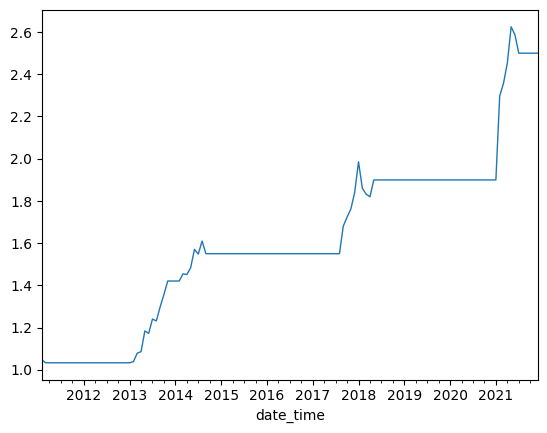

In [29]:
print((1 + top20_with_regime.beta20 * top20_with_regime.expansion).cumprod().plot(lw=1))
Metric(portfolio=(1 + top20_with_regime.beta20 * top20_with_regime.expansion).cumprod(), freq='month').print_report()

### 결론
- 베타 역시 확장국면과 획복국면에서 우상향하는 모습
- SPY 지수와 베타 팩터를 비교 후 시황포트폴리오의 성과지표 개선 여부를 확인해보자

### 자산군
    - 주식: sp500 index vs equity beta20
    - 장기채권: TLT ETF
    - 원자재: GSG ETF(tracking S&P GSCI index)
    - 달러: UUP index
    - 부동산: VNQ ETF

In [30]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
asset_df = asset_df.loc['2011':,:].dropna().resample('M').last()
asset_df

,SPY,TLT,GSG,VNQ,UUP
2011-01-31,102.406487,67.367363,35.160000,35.752144,21.478439
2011-02-28,105.963844,68.479080,36.090000,37.434372,21.219086
2011-03-31,105.976532,68.499161,37.349998,36.831436,20.930916
2011-04-30,109.045830,70.101410,38.939999,38.947971,20.124029
2011-05-31,107.822929,72.500877,36.270000,39.483395,20.498655
...,...,...,...,...,...
2022-10-31,384.444611,95.170647,21.850000,81.823532,29.767994
2022-11-30,405.816467,101.976341,21.590000,86.852455,28.360384
2022-12-31,382.429993,99.304520,21.230000,82.480003,27.809999
2023-01-31,406.480011,106.894997,21.209999,91.059998,27.510000


In [32]:
ma_regime_df = pd.merge(asset_df.pct_change(), top20_with_regime, left_index=True, right_index=True, how='left').dropna()
ma_regime_df

multi_asset_tickers = ['SPY', 'beta20', 'TLT', 'GSG', 'VNQ', 'UUP']

In [33]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,beta20,deflation,inflation,recovery,expansion
2011-02-28,0.034738,0.016502,0.026451,0.047053,-0.012075,0.047852,0.0,0.0,0.0,1.0
2011-03-31,0.000120,0.000293,0.034913,-0.016106,-0.013581,-0.013192,0.0,0.0,0.0,1.0
2011-04-30,0.028962,0.023391,0.042570,0.057465,-0.038550,0.010809,0.0,0.0,0.0,0.0
2011-05-31,-0.011215,0.034229,-0.068567,0.013747,0.018616,-0.042016,0.0,0.0,0.0,0.0
2011-06-30,-0.016870,-0.023231,-0.059553,-0.032993,-0.005623,-0.060484,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.029760,-0.003402,-0.023926,0.021545,0.004845,0.047454,0.0,0.0,0.0,0.0
2021-09-30,-0.046605,-0.029070,0.059711,-0.056815,0.016874,0.016810,0.0,0.0,0.0,0.0
2021-10-31,0.070163,0.024650,0.058719,0.071330,-0.002371,0.085261,0.0,0.0,0.0,0.0
2021-11-30,-0.008035,0.027715,-0.105882,-0.021093,0.017822,-0.011458,0.0,0.0,0.0,0.0


### 회복국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
Annualized Return: 6.08%
Annualized Volatility: 5.88%
Skewness: 2.94
Kurtosis: 12.72
Max Drawdown: -6.14%
Max Drawdown Duration: 365 days
Annualized Sharp Ratio: 0.35
Annualized Sortino Ratio: -1.84
Annualized Calmar Ratio: 0.99
Annualized VaR: -0.02
Annualized VaR Ratio: 0.22
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.16
Annualized hit Ratio: 0.81
Annualized GtP Ratio: 1.59

beta20
Annualized Return: 14.69%
Annualized Volatility: 14.85%
Skewness: 3.79
Kurtosis: 19.73
Max Drawdown: -7.66%
Max Drawdown Duration: 822 days
Annualized Sharp Ratio: 0.72
Annualized Sortino Ratio: -0.80
Annualized Calmar Ratio: 1.92
Annualized VaR: -0.04
Annualized VaR Ratio: 0.27
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.20
Annualized hit Ratio: 0.69
Annualized GtP Ratio: 3.03

TLT
Annualized Return: -0.93%
Annualized Volatility: 5.54%
Skewness: -0.60
Kurtosis: 9.27
Max Drawdown: -16.08%
Max Drawdown Duration: 1979 days
Annualized Sharp Ratio: -0.89
Annualize

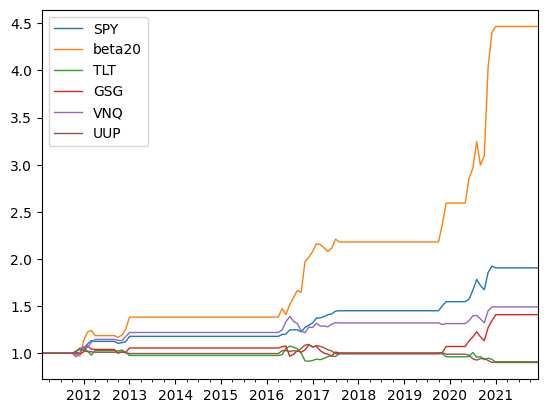

In [34]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['recovery'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.recovery).cumprod(), freq='month').print_report()
    print()

### 확장국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
Annualized Return: 5.22%
Annualized Volatility: 4.85%
Skewness: 1.54
Kurtosis: 4.22
Max Drawdown: -6.28%
Max Drawdown Duration: 1124 days
Annualized Sharp Ratio: 0.25
Annualized Sortino Ratio: -1.65
Annualized Calmar Ratio: 0.83
Annualized VaR: -0.03
Annualized VaR Ratio: 0.15
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.13
Annualized hit Ratio: 0.82
Annualized GtP Ratio: 1.16

beta20
Annualized Return: 8.29%
Annualized Volatility: 9.44%
Skewness: 3.88
Kurtosis: 24.08
Max Drawdown: -8.32%
Max Drawdown Duration: 1096 days
Annualized Sharp Ratio: 0.45
Annualized Sortino Ratio: -1.09
Annualized Calmar Ratio: 1.00
Annualized VaR: -0.04
Annualized VaR Ratio: 0.19
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.14
Annualized hit Ratio: 0.67
Annualized GtP Ratio: 2.62

TLT
Annualized Return: -0.46%
Annualized Volatility: 5.11%
Skewness: -0.83
Kurtosis: 7.35
Max Drawdown: -18.84%
Max Drawdown Duration: 3167 days
Annualized Sharp Ratio: -0.87
Annualized

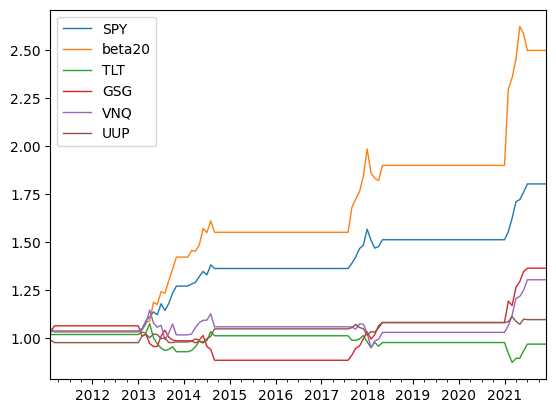

In [35]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['expansion'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.expansion).cumprod(), freq='month').print_report()
    print()

### 인플레이션 국면

AxesSubplot(0.125,0.11;0.775x0.77)


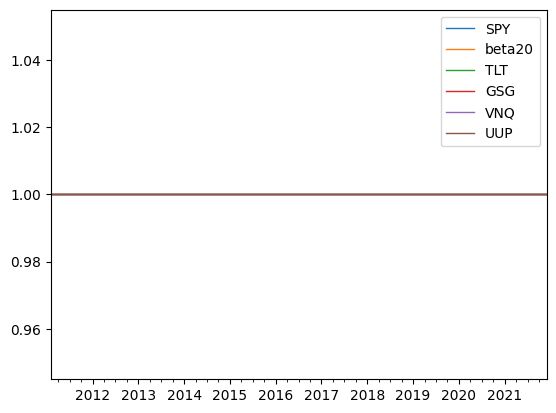

In [36]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['inflation'], axis=0)).cumprod().plot(lw=1))

# for ticker in multi_asset_tickers:
#     print(ticker)
#     Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.inflation).cumprod(), freq='month').print_report()
#     print()

### 디플레이션 국면

AxesSubplot(0.125,0.11;0.775x0.77)
SPY
Annualized Return: 1.36%
Annualized Volatility: 9.87%
Skewness: 0.39
Kurtosis: 8.06
Max Drawdown: -19.45%
Max Drawdown Duration: 2741 days
Annualized Sharp Ratio: -0.27
Annualized Sortino Ratio: -0.47
Annualized Calmar Ratio: 0.07
Annualized VaR: -0.08
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.10
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.58
Annualized GtP Ratio: 0.97

beta20
Annualized Return: -5.32%
Annualized Volatility: 25.28%
Skewness: 0.24
Kurtosis: 14.22
Max Drawdown: -61.40%
Max Drawdown Duration: 3837 days
Annualized Sharp Ratio: -0.37
Annualized Sortino Ratio: -0.23
Annualized Calmar Ratio: -0.09
Annualized VaR: -0.18
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.29
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.52
Annualized GtP Ratio: 0.83

TLT
Annualized Return: 6.86%
Annualized Volatility: 8.46%
Skewness: 3.03
Kurtosis: 10.13
Max Drawdown: -4.48%
Max Drawdown Duration: 1248 days
Annualized Sharp Ratio: 0.34
Annu

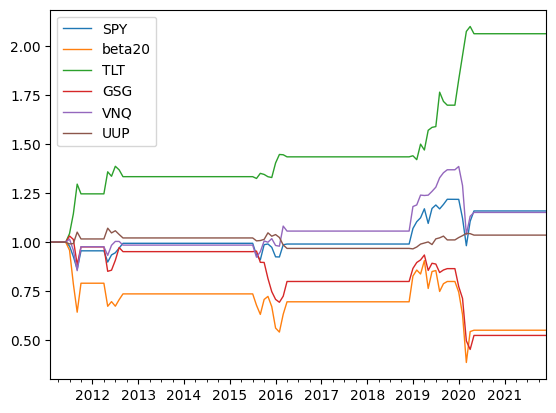

In [37]:
print((1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['deflation'], axis=0)).cumprod().plot(lw=1))

for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.deflation).cumprod(), freq='month').print_report()
    print()

### 결론
- 확장기와 회복기에 SPY 지수보다 좋은 성과를 보이는 베타 팩터
- 반대로 디플레이션 국면에서는 모든 지수를 하회하는 성과를 보였다

### SPY 지수를 대신해 베타 팩터를 사용한 시황포트폴리오를 만든 후 성과지표를 확인해보자

In [38]:
best_regime = pd.concat([
                        ma_regime_df.loc[(ma_regime_df.recovery == 1)]['beta20'], 
                        ma_regime_df.loc[(ma_regime_df.expansion == 1)]['beta20'],
                        ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT'],
                        ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP'],
                        ], ignore_index=False, axis=0)

best_regime

2011-11-30   -0.015728
2011-12-31   -0.013723
2012-01-31    0.168326
2012-02-29    0.080289
2012-03-31    0.014856
                ...   
2020-01-31    0.076911
2020-02-29    0.066265
2020-03-31    0.063767
2020-04-30    0.012190
2020-05-31   -0.017619
Length: 103, dtype: float64

In [39]:
type(best_regime.index)
type(ma_regime_df.index)

best_regime.index = pd.to_datetime(best_regime.index)
best_regime.index

DatetimeIndex(['2011-11-30', '2011-12-31', '2012-01-31', '2012-02-29',
               '2012-03-31', '2012-04-30', '2012-10-31', '2012-11-30',
               '2012-12-31', '2013-01-31',
               ...
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31'],
              dtype='datetime64[ns]', length=103, freq=None)

In [40]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained

DatetimeIndex(['2011-04-30', '2011-05-31', '2011-06-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq=None)

In [41]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained_df = pd.Series({'port_val':0}, index=not_explained)

In [42]:
total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_58126/2470937050.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)


AxesSubplot(0.125,0.11;0.775x0.77)
Annualized Return: 32.72%
Annualized Volatility: 18.25%
Skewness: 1.99
Kurtosis: 6.76
Max Drawdown: -8.32%
Max Drawdown Duration: 487 days
Annualized Sharp Ratio: 1.57
Annualized Sortino Ratio: -0.38
Annualized Calmar Ratio: 3.93
Annualized VaR: -0.06
Annualized VaR Ratio: 0.44
Annualized CVaR: -0.07
Annualized CVaR Ratio: 0.36
Annualized hit Ratio: 0.64
Annualized GtP Ratio: 3.23


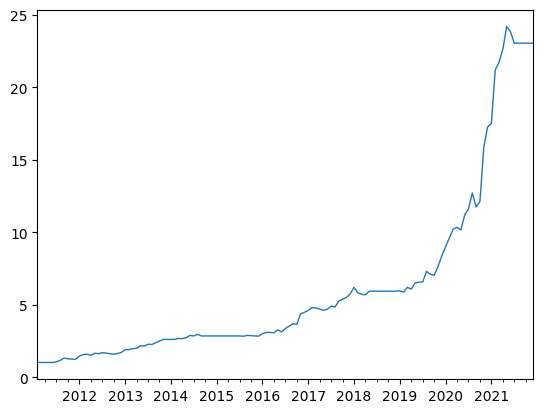

In [43]:
print((1 + total_regime).cumprod().plot(lw=1))
Metric(portfolio=(1 + total_regime).cumprod(), freq='month').print_report()

    - SPY지수를 포함한 시황포트폴리오의 성과지표
  
      Annualized Return: 18.60% 
      Annualized Volatility: 12.41%
      Skewness: 0.53
      Kurtosis: 2.98
      Max Drawdown: -17.13%
      Max Drawdown Duration: 487 days
      Annualized Sharp Ratio: 1.18
      Annualized Sortino Ratio: -0.39
      Annualized Calmar Ratio: 1.09
      Annualized VaR: -0.07
      Annualized VaR Ratio: 0.21
      Annualized CVaR: -0.11
      Annualized CVaR Ratio: 0.14
      Annualized hit Ratio: 0.70
      Annualized GtP Ratio: 1.63

### 결론
- SPY 지수 대신 베타 팩터를 사용한 경우 성과지표가 개선 되었다. 
- 연율화 수익률의 경우 약 14%포인트 상승
- 변동성은 약 6%포인트 상승
- 연율화 수익률의 상승이 변동성의 상승 폭을 상충시켜 샤프비율 역시 약 0.4 상승하였다.
- MDD 역시 -17.13%에서 -8.32%로 크게 개선되었다. 